## Data Loading 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import torch
import torch.nn as nn
import torch.optim as optim

from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('/6_class.csv')

Let's examine the general information about the obtained DataFrame, display the first few rows, and plot histograms for the columns of the table.

In [3]:
df.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


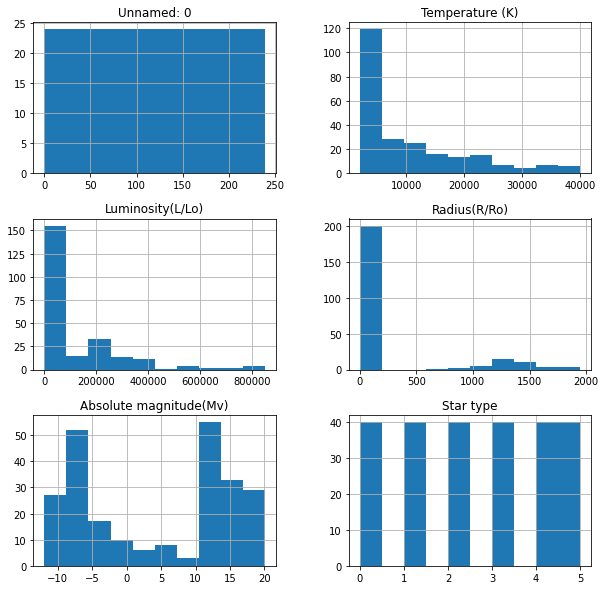

In [5]:
df.hist(figsize=(10,10));

Based on the provided histograms, several concerns can be identified:

1. The `Unnamed: 0` column might simply be an index and could be redundant.

2. The `Temperature (K)` distribution is heavily skewed towards lower temperatures, with a long tail extending to higher values.

3. The `Luminosity (L/Lo)` distribution is also highly skewed and might require normalization.

4. The `Radius (R/Ro)` shows a heavy skew, with most stars having a relatively small radius.

5. The `Absolute Magnitude (Mv)` histogram shows a bimodal distribution, which indicates two distinct groups of stars with different magnitudes. 

6. The `Star Type` histogram shows a relatively even distribution across different types, which is generally a good sign for a balanced dataset regarding this feature.

## Data Exploration and Preparation 

It looks like the `Unnamed: 0` column is useless as it replicates the row number. Let's make sure that's the case.

In [6]:
(df['Unnamed: 0'] == df.index).all()

True

Yep, that's true, the `Unnamed: 0` column is redundant, let's get rid of it.

In [7]:
df.drop('Unnamed: 0', axis=1, inplace=True)

Let's find out the number of explicit duplicates using the `duplicated()` method.

In [8]:
df.duplicated().sum()

0

Let's make sure there is no missing data.

In [9]:
df.isna().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

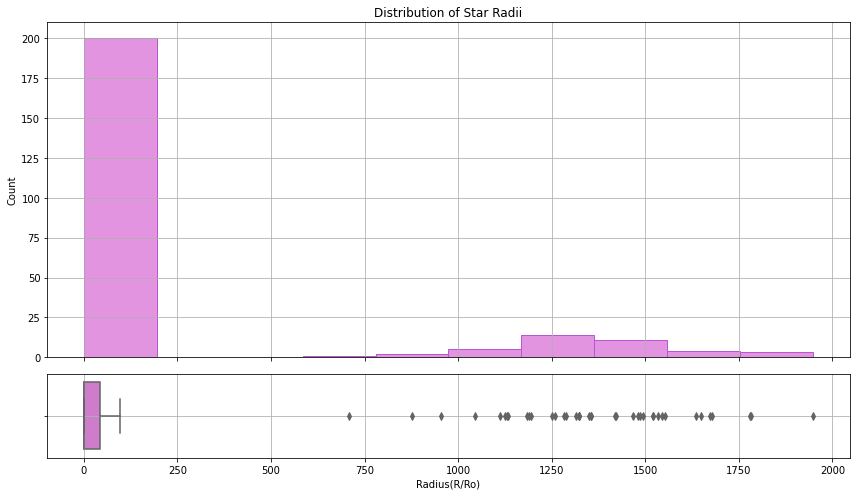

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

sns.histplot(df['Radius(R/Ro)'], bins=10, color='#DA70D6', edgecolor='#BA55D3', ax=ax1)
ax1.set_title('Distribution of Star Radii')
ax1.grid(True)

sns.boxplot(x=df['Radius(R/Ro)'], ax=ax2, color='#DA70D6')
ax2.grid(True)

sns.set_style("whitegrid")

plt.tight_layout()

The distribution is heavily skewed to the right and the box plot clearly shows numerous outliers beyond the upper whisker. A majority of the data points are concentrated in the first bin, indicating that most stars have a radius very close to 0. 

The thing is, the relative radius cannot be zero because it would imply the star has no size, which is not possible for a physical star. 

I'm not sure if those are zeros for sure, so let's check.

In [11]:
df['Radius(R/Ro)'].describe()

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: Radius(R/Ro), dtype: float64

Okay, no zeros, just some close-to-zero values. 

Let's check if the `Luminosity(L/Lo)` (the luminosity of a star relative to the Sun) column has a similar problem. 

Theoretically, the relative luminosity can approach zero for very dim stars or objects like brown dwarfs, but it cannot be exactly zero for an actual star, as that would imply the star emits no light at all, which contradicts the definition of a star. 

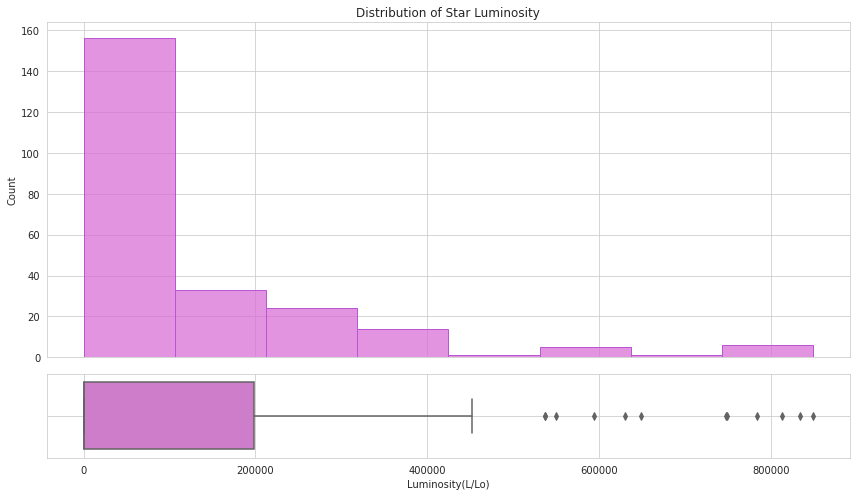

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

sns.histplot(df['Luminosity(L/Lo)'], bins=8, color='#DA70D6', edgecolor='#BA55D3', ax=ax1)
ax1.set_title('Distribution of Star Luminosity')
ax1.grid(True)

sns.boxplot(x=df['Luminosity(L/Lo)'], ax=ax2, color='#DA70D6')
ax2.grid(True)

plt.tight_layout()

The histogram shows the exponential distribution which is memoryless, meaning the probability of an event occurring in the future is independent of the past. We also can see some outliers.

In [13]:
df['Luminosity(L/Lo)'].describe()

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: Luminosity(L/Lo), dtype: float64

Again, close to zero, but not zero. No problem here.

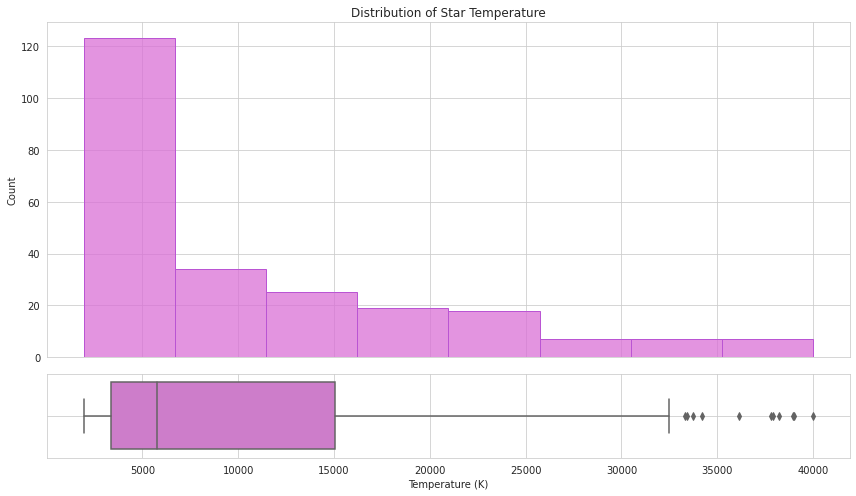

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

sns.histplot(df['Temperature (K)'], bins=8, color='#DA70D6', edgecolor='#BA55D3', ax=ax1)
ax1.set_title('Distribution of Star Temperature')
ax1.grid(True)

sns.boxplot(x=df['Temperature (K)'], ax=ax2, color='#DA70D6')
ax2.grid(True)

plt.tight_layout()

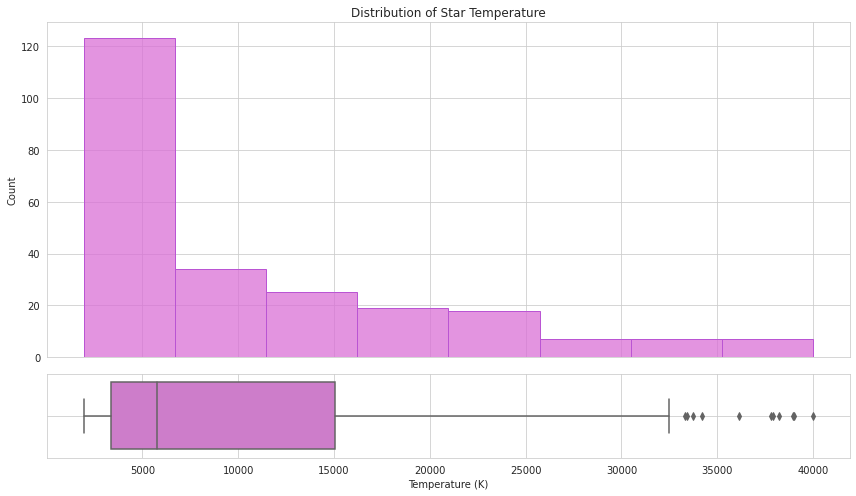

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

sns.histplot(df['Temperature (K)'], bins=8, color='#DA70D6', edgecolor='#BA55D3', ax=ax1)
ax1.set_title('Distribution of Star Temperature')
ax1.grid(True)

sns.boxplot(x=df['Temperature (K)'], ax=ax2, color='#DA70D6')
ax2.grid(True)

plt.tight_layout()

Same thing here. We have a significant number of outliers in the numerical columns, comprising about 30% of the dataset. Removing these outliers could negatively impact the model's predictive accuracy, as they represent a substantial portion of the data.

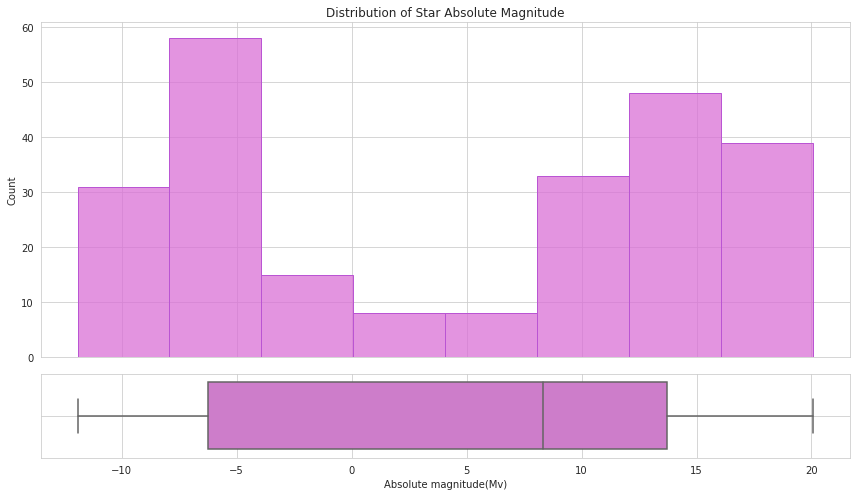

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

sns.histplot(df['Absolute magnitude(Mv)'], bins=8, color='#DA70D6', edgecolor='#BA55D3', ax=ax1)
ax1.set_title('Distribution of Star Absolute Magnitude')
ax1.grid(True)

sns.boxplot(x=df['Absolute magnitude(Mv)'], ax=ax2, color='#DA70D6')
ax2.grid(True)

plt.tight_layout()

The histogram shows a bimodal distribution with two prominent peaks. The bimodal distribution suggests the presence of two main groups of stars. The first group consists of very luminous stars (possibly giant stars or early-type main sequence stars), and the second group consists of less luminous stars (possibly later-type main sequence stars or dwarfs).

Now let's explore categorical columns.


In [17]:
df['Star type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: Star type, dtype: int64

We got the perfect class balance!

In [18]:
df['Star color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
yellowish               2
Whitish                 2
Orange                  2
Blue-White              1
Pale yellow orange      1
Blue white              1
Blue                    1
White-Yellow            1
Yellowish               1
Orange-Red              1
Name: Star color, dtype: int64

Oh, well, not so perfect of a situation here. We can see that some of the same colors are written in different ways, let's change that and make everything lowercase for increased visbility.

In [19]:
df['Star color'] = df['Star color'].str.lower()
df['Star color'] = df['Star color'].str.strip()

In [20]:
df['Star color'].value_counts()

red                   112
blue                   56
blue-white             27
blue white             14
white                  10
yellow-white            8
yellowish white         3
yellowish               3
orange                  2
whitish                 2
pale yellow orange      1
orange-red              1
white-yellow            1
Name: Star color, dtype: int64

In [21]:
def star_color_filter(color):
    if color == 'blue white':
        return 'blue-white'
    elif color in ['yellowish white', 'white-yellow']:
        return 'yellow-white'
    elif color == 'yellowish':
        return 'yellow'
    elif color == 'whitish':
        return 'white'
    elif color == 'pale yellow orange':
        return 'yellow'
    else:
        return color

In [22]:
df['Star color'] = df['Star color'].apply(star_color_filter)

In [23]:
df['Star color'].value_counts()

red             112
blue             56
blue-white       41
yellow-white     12
white            12
yellow            4
orange            2
orange-red        1
Name: Star color, dtype: int64

Now we have less color name which are more readable!

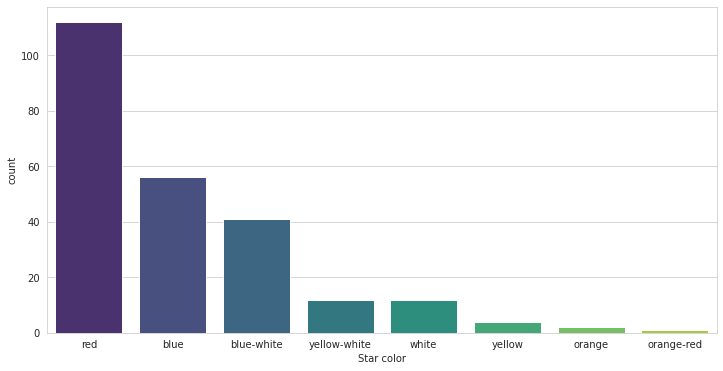

In [24]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Star color', data=df, palette='viridis', order=df['Star color'].value_counts().index);

The current class distribution is imbalanced, which could pose challenges when training our model. To address this, we can consolidate the less frequent classes into a single class labeled 'others'. This approach will result in four classes: red, blue, blue-white, and others.

In [25]:
other_colors = ['yellow', 'orange', 'orange-red']
df['Star color'] = df['Star color'].apply(lambda color: 'others' if color in other_colors else color)

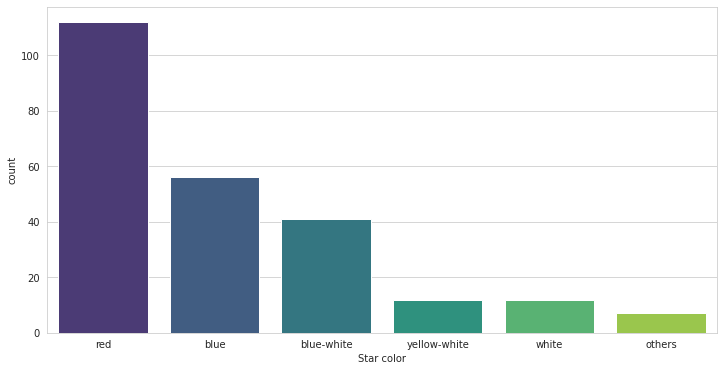

In [26]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Star color', data=df, palette='viridis', order=df['Star color'].value_counts().index);

That's better. Now let's split the data into training and testing sets.

In [27]:
target = 'Temperature (K)'
numerical_cols = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
categorical_cols = ['Star type', 'Star color']

state = 73 # a 'perfect' number can't hurt

In [28]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(target, axis=1), 
                                                    df[target], 
                                                    train_size=0.75, 
                                                    random_state=state, 
                                                    shuffle=True)

## Baseline Neural Network Model

Let's start on the feature scaling. We'll be creating a pipeline for that. We're going to use One-Hot Encoding for categorical data and Robust Scaler for numerical data since it's effective at handling outliers by scaling the data based on the interquartile range.

In [29]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

preprocessor.fit(x_train)

x_train_preprocessed = preprocessor.transform(x_train)
x_test_preprocessed = preprocessor.transform(x_test)

Now we're ready to start working on creating a neural netork.

Converting preprocessed data to PyTorch tensors.

In [30]:
x_train, x_test = map(lambda x: torch.tensor(x, dtype=torch.float32), [x_train_preprocessed, x_test_preprocessed])
y_train, y_test = map(lambda y: torch.tensor(y.values, dtype=torch.float32).view(-1, 1), [y_train, y_test])

First, let's define a simple neural network architecture.

In [31]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [32]:
input_size = x_train.shape[1]
hidden_size = 32
num_classes = 1
learning_rate = 0.01
num_epochs = 10000
batch_size = 32

In [33]:
model = SimpleNeuralNet(input_size, hidden_size, num_classes)

In [34]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [89]:
def train_model(model, criterion, optimizer, x_train, y_train, num_epochs, batch_size):
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(x_train), batch_size):
            batch_x = x_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        if (epoch + 1) % 250 == 0:
            rmse_train = np.sqrt(np.mean(train_losses[-len(x_train) // batch_size:]))
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train RMSE: {rmse_train:.0f}')
            model.eval()
            with torch.no_grad():
                predictions = model(x_test).numpy()
                rmse_test = np.sqrt(mean_squared_error(y_test.numpy(), predictions))
                print(f'RMSE on Test Set: {rmse_test:.0f}')
    return train_losses

In [36]:
print(f'x_train_preprocessed shape: {x_train_preprocessed.shape}')
print(f'x_test_preprocessed shape: {x_test_preprocessed.shape}')

x_train_preprocessed shape: (180, 15)
x_test_preprocessed shape: (60, 15)


Using th common heuristic: the number of neurons in the hidden layer is typically between the size of the input layer and the size of the output layer, so we're starting with 10, and going to be adjusting this number later on.

In [37]:
train_losses = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, batch_size)

Epoch [10/10000], Train RMSE: 13483
RMSE on Test Set: 15858
Epoch [20/10000], Train RMSE: 13213
RMSE on Test Set: 15377
Epoch [30/10000], Train RMSE: 12795
RMSE on Test Set: 14613
Epoch [40/10000], Train RMSE: 12387
RMSE on Test Set: 13843
Epoch [50/10000], Train RMSE: 12032
RMSE on Test Set: 13258
Epoch [60/10000], Train RMSE: 11664
RMSE on Test Set: 12838
Epoch [70/10000], Train RMSE: 11235
RMSE on Test Set: 12478
Epoch [80/10000], Train RMSE: 10738
RMSE on Test Set: 12120
Epoch [90/10000], Train RMSE: 10189
RMSE on Test Set: 11741
Epoch [100/10000], Train RMSE: 9611
RMSE on Test Set: 11337
Epoch [110/10000], Train RMSE: 9027
RMSE on Test Set: 10915
Epoch [120/10000], Train RMSE: 8461
RMSE on Test Set: 10491
Epoch [130/10000], Train RMSE: 7935
RMSE on Test Set: 10083
Epoch [140/10000], Train RMSE: 7463
RMSE on Test Set: 9705
Epoch [150/10000], Train RMSE: 7058
RMSE on Test Set: 9365
Epoch [160/10000], Train RMSE: 6722
RMSE on Test Set: 9066
Epoch [170/10000], Train RMSE: 6451
RMSE on

In [38]:
model.eval()
with torch.no_grad():
    predictions = model(x_test).numpy()
    rmse_test = np.sqrt(mean_squared_error(y_test.numpy(), predictions))
    print(f'RMSE on Test Set: {rmse_test:.0f}')

RMSE on Test Set: 5971


Let's plot the "Actual vs. Predicted" graph.

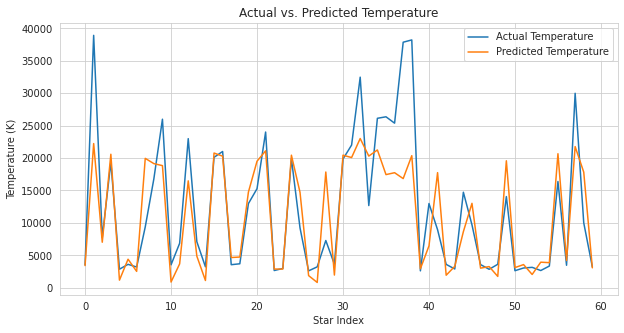

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test.cpu().numpy(), label='Actual Temperature')
plt.plot(range(len(y_test)), predictions, label='Predicted Temperature')
plt.xlabel('Star Index')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Actual vs. Predicted Temperature')
plt.show()

The model predicts temperatures within a limited range, up to approximately 24,000, and is unable to predict high temperatures. However, it performs well at predicting low temperatures.

## Improving the Network

Let's try adding DropOut to the model.

In [40]:
class DropoutNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.5):
        super(DropoutNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)  # adding dropout
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

All parameters will remain the same.

In [41]:
input_size = x_train.shape[1]
hidden_size = 64
num_classes = 1
learning_rate = 0.01
num_epochs = 10000
batch_size = 32

In [42]:
model = DropoutNeuralNet(input_size, hidden_size, num_classes)

In [43]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Model training.

In [44]:
train_losses = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, batch_size)

Epoch [10/10000], Train RMSE: 13443
RMSE on Test Set: 15782
Epoch [20/10000], Train RMSE: 12998
RMSE on Test Set: 14977
Epoch [30/10000], Train RMSE: 12365
RMSE on Test Set: 13897
Epoch [40/10000], Train RMSE: 11888
RMSE on Test Set: 13088
Epoch [50/10000], Train RMSE: 11409
RMSE on Test Set: 12540
Epoch [60/10000], Train RMSE: 10704
RMSE on Test Set: 12044
Epoch [70/10000], Train RMSE: 9953
RMSE on Test Set: 11494
Epoch [80/10000], Train RMSE: 9165
RMSE on Test Set: 10922
Epoch [90/10000], Train RMSE: 8469
RMSE on Test Set: 10375
Epoch [100/10000], Train RMSE: 7837
RMSE on Test Set: 9867
Epoch [110/10000], Train RMSE: 7151
RMSE on Test Set: 9417
Epoch [120/10000], Train RMSE: 6723
RMSE on Test Set: 9030
Epoch [130/10000], Train RMSE: 6438
RMSE on Test Set: 8789
Epoch [140/10000], Train RMSE: 5967
RMSE on Test Set: 8469
Epoch [150/10000], Train RMSE: 6018
RMSE on Test Set: 8263
Epoch [160/10000], Train RMSE: 5867
RMSE on Test Set: 8120
Epoch [170/10000], Train RMSE: 6159
RMSE on Test S

In [45]:
model.eval()
with torch.no_grad():
    predictions = model(x_test).numpy()
    rmse_test = np.sqrt(mean_squared_error(y_test.numpy(), predictions))
    print(f'RMSE on Test Set: {rmse_test:.0f}')

RMSE on Test Set: 4805


It only got worse. This is logical, since we already have a small amount of data, and DropOut further reduces the effective quantity.

"Actual vs. Predicted" graph.

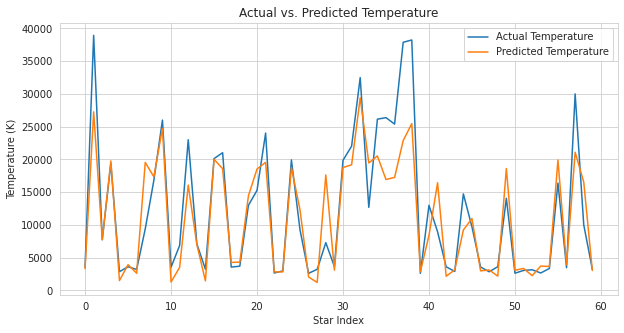

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test.numpy(), label='Actual Temperature')
plt.plot(range(len(y_test)), predictions, label='Predicted Temperature')
plt.xlabel('Star Index')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Actual vs. Predicted Temperature')
plt.show()

Let's try a different approach, remove DropOut, and add BatchNorm.

In [47]:
class BatchNormNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BatchNormNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size) # adding batch normalization
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out) # adding batch normalization
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [48]:
input_size = x_train.shape[1]
hidden_size = 32
num_classes = 1
learning_rate = 0.1
num_epochs = 20000
batch_size = 64

In [49]:
model = BatchNormNeuralNet(input_size, hidden_size, num_classes)

In [50]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
train_losses = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, batch_size)

Epoch [10/20000], Train RMSE: 13045
RMSE on Test Set: 15549
Epoch [20/20000], Train RMSE: 11362
RMSE on Test Set: 13623
Epoch [30/20000], Train RMSE: 8422
RMSE on Test Set: 10430
Epoch [40/20000], Train RMSE: 5737
RMSE on Test Set: 7591
Epoch [50/20000], Train RMSE: 4969
RMSE on Test Set: 7713
Epoch [60/20000], Train RMSE: 4724
RMSE on Test Set: 5743
Epoch [70/20000], Train RMSE: 4675
RMSE on Test Set: 5911
Epoch [80/20000], Train RMSE: 4627
RMSE on Test Set: 5929
Epoch [90/20000], Train RMSE: 4593
RMSE on Test Set: 6096
Epoch [100/20000], Train RMSE: 4581
RMSE on Test Set: 6037
Epoch [110/20000], Train RMSE: 4509
RMSE on Test Set: 5851
Epoch [120/20000], Train RMSE: 4468
RMSE on Test Set: 5997
Epoch [130/20000], Train RMSE: 4433
RMSE on Test Set: 6032
Epoch [140/20000], Train RMSE: 4405
RMSE on Test Set: 6048
Epoch [150/20000], Train RMSE: 4379
RMSE on Test Set: 6165
Epoch [160/20000], Train RMSE: 4370
RMSE on Test Set: 6228
Epoch [170/20000], Train RMSE: 4321
RMSE on Test Set: 6027
E

In [52]:
model.eval()
with torch.no_grad():
    predictions = model(x_test).numpy()
    rmse_test = np.sqrt(mean_squared_error(y_test.numpy(), predictions))
    print(f'RMSE on Test Set: {rmse_test:.0f}')

RMSE on Test Set: 16390


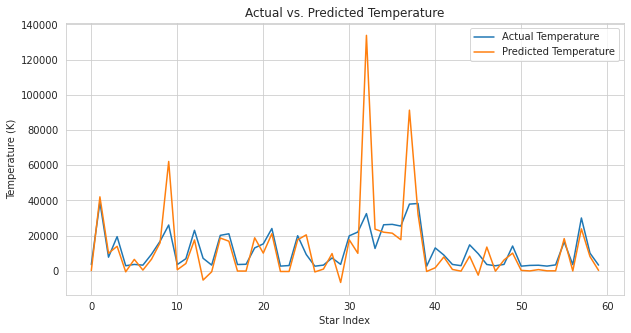

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test.numpy(), label='Actual Temperature')
plt.plot(range(len(y_test)), predictions, label='Predicted Temperature')
plt.xlabel('Star Index')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Actual vs. Predicted Temperature')
plt.show()

Let's try replacing ReLU with other activation functions and see which one works better. Spoiler: ELU.

In [54]:
class ELUNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ELUNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size) # adding batch normalization
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out) # adding batch normalization
        out = self.elu(out) 
        out = self.fc2(out)
        return out

Let's try Grid Search.

In [96]:
def grid_train_model(model, criterion, optimizer, x_train, y_train, num_epochs, batch_size):
    model.train()
    for epoch in range(num_epochs):
        permutation = torch.randperm(x_train.size()[0])
        for i in range(0, x_train.size()[0], batch_size):
            indices = permutation[i:i + batch_size]
            batch_x, batch_y = x_train[indices], y_train[indices]

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    return model

def grid_evaluate_model(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(x_test).numpy()
        rmse_test = np.sqrt(mean_squared_error(y_test.numpy(), predictions))
    return rmse_test

In [97]:
hidden_sizes = [8, 16, 32, 64, 128]
learning_rates = [0.1, 0.01]
num_epochs = 10000
batch_sizes = [8, 16, 32, 64, 128]

best_rmse = float('inf')
best_params = {}

In [98]:
for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            model = ELUNeuralNet(input_size, hidden_size, num_classes)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            model = grid_train_model(model, criterion, optimizer, x_train, y_train, num_epochs, batch_size)
            rmse_test = grid_evaluate_model(model, x_test, y_test)

            if rmse_test < best_rmse:
                best_rmse = rmse_test
                best_params = {
                    'hidden_size': hidden_size,
                    'learning_rate': learning_rate,
                    'num_epochs': num_epochs,
                    'batch_size': batch_size
                }

            print(f'Hidden Size: {hidden_size}, Learning Rate: {learning_rate}, Epochs: {num_epochs}, Batch Size: {batch_size}, RMSE: {rmse_test:.4f}')

print(f'Best Parameters: {best_params}, Best RMSE: {best_rmse:.4f}')

Hidden Size: 8, Learning Rate: 0.1, Epochs: 10000, Batch Size: 8, RMSE: 4949.1577
Hidden Size: 8, Learning Rate: 0.1, Epochs: 10000, Batch Size: 16, RMSE: 6025.5146
Hidden Size: 8, Learning Rate: 0.1, Epochs: 10000, Batch Size: 32, RMSE: 4559.4478
Hidden Size: 8, Learning Rate: 0.1, Epochs: 10000, Batch Size: 64, RMSE: 4975.8481
Hidden Size: 8, Learning Rate: 0.1, Epochs: 10000, Batch Size: 128, RMSE: 5183.5674
Hidden Size: 8, Learning Rate: 0.01, Epochs: 10000, Batch Size: 8, RMSE: 6086.5195
Hidden Size: 8, Learning Rate: 0.01, Epochs: 10000, Batch Size: 16, RMSE: 5939.9097
Hidden Size: 8, Learning Rate: 0.01, Epochs: 10000, Batch Size: 32, RMSE: 4846.2734
Hidden Size: 8, Learning Rate: 0.01, Epochs: 10000, Batch Size: 64, RMSE: 4678.4502
Hidden Size: 8, Learning Rate: 0.01, Epochs: 10000, Batch Size: 128, RMSE: 4718.7241
Hidden Size: 16, Learning Rate: 0.1, Epochs: 10000, Batch Size: 8, RMSE: 5420.9189
Hidden Size: 16, Learning Rate: 0.1, Epochs: 10000, Batch Size: 16, RMSE: 7400.465

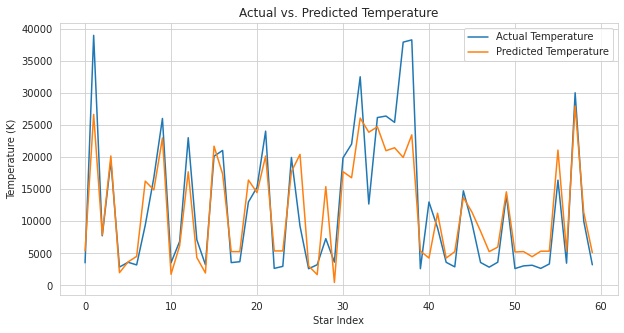

In [140]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test.numpy(), label='Actual Temperature')
plt.plot(range(len(y_test)), predictions, label='Predicted Temperature')
plt.xlabel('Star Index')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Actual vs. Predicted Temperature')
plt.show()

## Project Conclusions

After many years of performing Grid Search, the best hyperparameters were found! The network trained well and showed an RMSE of 4400 (less than 4500, hooray) on the test set! In the end, the architecture with one hidden layer, batch normalization, and the ELU activation function won.